# Wrangling Data From Bay Area Bike Share Published Data - Trips

### Import Packages

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import datetime
import math
import numpy as np

import seaborn as sns
sns.set_style('whitegrid')
sns.set_context("poster")

<p> Set some notebook variables, makes the notebook 95% width of the screen for easier viewing</p>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

<p> Set some global font sizes for plots </p>

In [3]:
font = {'size'   : 50}
matplotlib.rc('font', **font)

LABEL_FONT_SIZE = 15
TITLE_FONT_SIZE = 25

## Import Data

In [4]:
print('Started Loading Station Data...')
file_path_slug = '../source_data/bayareabikeshare/*trip_data.csv'
file_list = glob(file_path_slug)

trips = pd.DataFrame()

counter = 1
chunks = []

for file in file_list:
    
    chunk_counter = 1
    num_chunks = math.ceil(sum(1 for row in open(file, 'r'))/10000)
    
    for chunk in pd.read_csv(file, chunksize=10000, iterator=True):
        # define Columns
        chunk.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_terminal', 'end_date', 
                         'end_station_name', 'end_terminal', 'bike_id', 'subscriber_type', 'zip_code']

        # append chunk to chunks list
        chunks.append(chunk)

        if chunk_counter == 1 or chunk_counter % math.ceil(num_chunks/10) == 0 or chunk_counter == num_chunks:
            print('\t[%s] finished chunk %s of %s' % (datetime.datetime.now().time(), chunk_counter, num_chunks))
        chunk_counter += 1
        
    print('Finished file! (%d of %d)' % (counter, len(file_list)))
    counter += 1
    
trips = pd.concat(chunks)
print('Data Loaded Successfully!')

Started Loading Station Data...
	[01:00:19.630766] finished chunk 1 of 32
	[01:00:19.732525] finished chunk 4 of 32
	[01:00:19.869960] finished chunk 8 of 32
	[01:00:20.016848] finished chunk 12 of 32
	[01:00:20.180937] finished chunk 16 of 32
	[01:00:20.347723] finished chunk 20 of 32
	[01:00:20.491107] finished chunk 24 of 32
	[01:00:20.638238] finished chunk 28 of 32
	[01:00:20.762560] finished chunk 32 of 32
Finished file! (1 of 4)
	[01:00:20.896023] finished chunk 1 of 15
	[01:00:20.932417] finished chunk 2 of 15
	[01:00:21.011008] finished chunk 4 of 15
	[01:00:21.079406] finished chunk 6 of 15
	[01:00:21.154147] finished chunk 8 of 15
	[01:00:21.224838] finished chunk 10 of 15
	[01:00:21.302113] finished chunk 12 of 15
	[01:00:21.376515] finished chunk 14 of 15
	[01:00:21.394094] finished chunk 15 of 15
Finished file! (2 of 4)
	[01:00:21.680141] finished chunk 1 of 36
	[01:00:21.779311] finished chunk 4 of 36
	[01:00:21.920853] finished chunk 8 of 36
	[01:00:22.064282] finished 

## Cleaning Support Functions
<p>General Cleaning functions</p>

In [5]:
def clean_zipcode(item):
    ''' Zipcodes in this data set are self reported rider zipcodes
        and the method of entry for these zipcodes is reported to 
        not be very clear for users, we are using a heavy hand 
        when cleaning up zip codes'''

    zip_string = str(item)
    
    # if zipcode is not 5 characters long
    if len(zip_string) > 5:
        # try splitting on a few different characters

        # split on '-'
        try:
            result = zip_string.split('-')[0]
        except:
            result = zip_string
        
        # split on '.'
        try:
            result = zip_string.split('.')[0]
        except:
            result = zip_string
            
        # take only first 5 characters
        result = result[:5]

        # if len of zipstring is less than 5, return 'NaN'
        if len(result) < 5:
            return 99999

    # if it is 5 characters long, move along
    else:
        result = zip_string
    
    # make sure result is all digits
    if result.isdigit():
        result = int(result)
        return result
    else:
        return 99999


def clean_trip_frame(df):
    '''Basic Cleanup of column types and appends a 'duration_minutes' 
        column converted from given 'duration' which is in seconds'''
    # set column types
    df['start_date']       = pd.to_datetime(df['start_date'], format="%m/%d/%Y %H:%M")
    df['end_date']         = pd.to_datetime(df['end_date'],   format="%m/%d/%Y %H:%M")
    df['trip_id']          = df['trip_id'].astype('int')
    df['duration']         = df['duration'].astype('int')    
    df['start_terminal']   = df['start_terminal'].astype('int')
    df['end_terminal']     = df['end_terminal'].astype('int')
    df['bike_id']          = df['bike_id'].astype('int')
    df['subscriber_type']  = df['subscriber_type'].astype('category')
    
    # add 'duration_minutes' column
    df['duration_minutes'] = df['duration'] / 60.
    df['duration_minutes'] = df['duration_minutes'].astype('float')
    
    # Clean Zipcode
    df['zip_code'] = df.zip_code.apply(clean_zipcode)
    
    # rename columns for clarity
    df.rename(columns={'zip_code': 'user_zip', 'subscriber_type': 'user_type'}, inplace=True)

    return df

# Cleaning Data
<p>Format zip codes to take only first 5 digits, this data is self reported and often wrongly input per Bay Area Bike Share Notes</p>

In [6]:
# clean data frames
print('[%s] Trip Data Cleanup Started' % datetime.datetime.now().time())
trips = clean_trip_frame(trips)

print('[%s] Cleaning Duplicates and Reindexing Trip Data' % datetime.datetime.now().time())
trips.drop_duplicates(inplace=True)
trips.sort_values('trip_id', inplace=True)
trips.reset_index(inplace=True, drop=True)

print('[%s] Cleanup Complete!' % datetime.datetime.now().time())

[01:00:24.192029] Trip Data Cleanup Started
[01:00:35.962544] Cleaning Duplicates and Reindexing Trip Data
[01:00:37.568561] Cleanup Complete!


In [7]:
trips.shape

(983648, 12)

## Prune  by Duration
<p>The distribution of trips is heavily left skewed, pruning trips longer than 24 hours minutes in duration helps get a beter picture of the important data points</p>

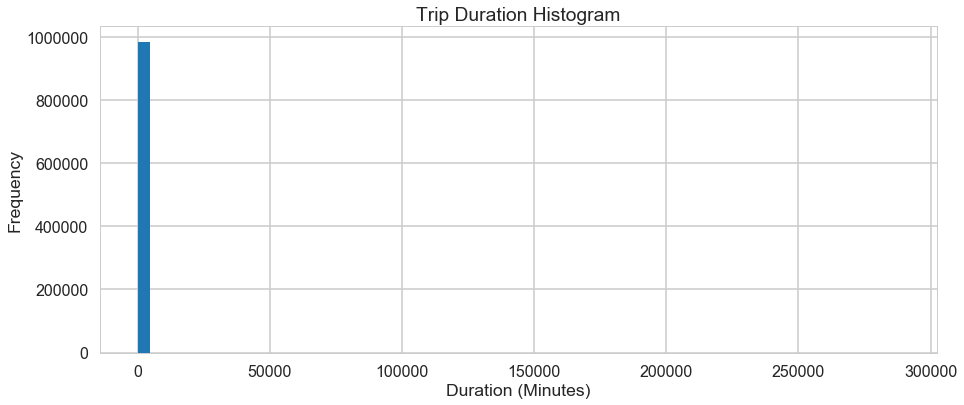

In [8]:
trips.duration_minutes.plot(kind='hist', bins=60, figsize=(15,6))
plt.xlabel('Duration (Minutes)')
plt.ylabel('Frequency')
plt.title('Trip Duration Histogram')
plt.show()
plt.close()

## Prune Trips more than 24 hours

In [9]:
# prune data to exclude trips longer than 24 hours
print('[%s] - Removing trips longer than 24 hours' % (datetime.datetime.now().time()))
cutoff = 24*60
trips = trips[trips.duration_minutes < cutoff]
trips.reset_index(inplace=True, drop=True)
print(trips.shape)
print('[%s] - Complete' % (datetime.datetime.now().time()))

[01:00:38.385301] - Removing trips longer than 24 hours
(983352, 12)
[01:00:38.505915] - Complete


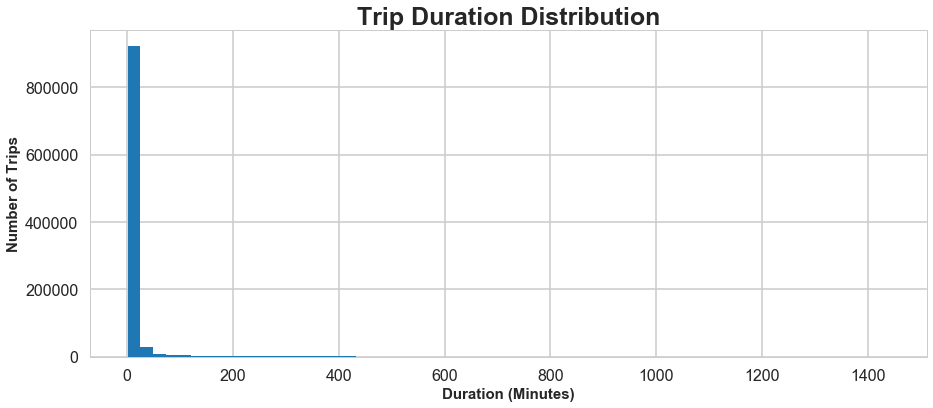

In [10]:
trips.duration_minutes.plot(kind='hist', bins=60, figsize=(15,6))
plt.xlabel('Duration (Minutes)', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
plt.title('Trip Duration Distribution', size=TITLE_FONT_SIZE, weight='bold')
plt.show()
plt.close()

## Split into Trips less than 30 Minuts and Trips less than 2 Hours

In [11]:
trips_under_30  = trips[trips.duration_minutes < 30].copy()
trips_under_120 = trips[trips.duration_minutes < 120].copy()

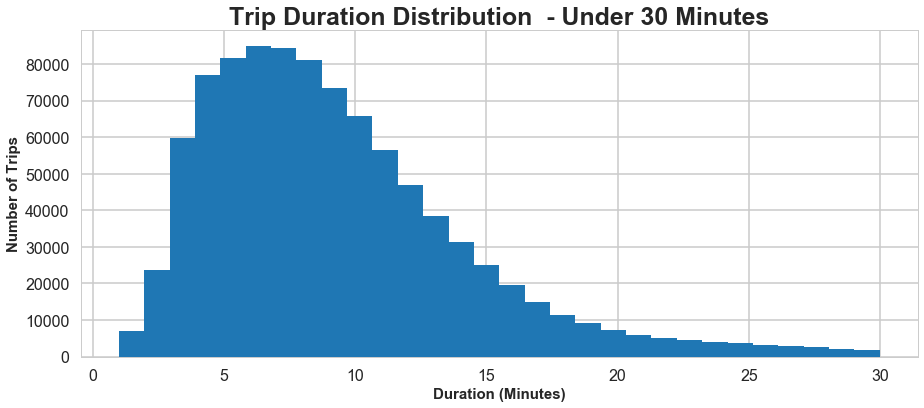

In [12]:
trips_under_30.duration_minutes.plot(kind='hist', bins=30, figsize=(15,6))
plt.xlabel('Duration (Minutes)', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
plt.title('Trip Duration Distribution  - Under 30 Minutes', size=TITLE_FONT_SIZE, weight='bold')
plt.show()
plt.close()

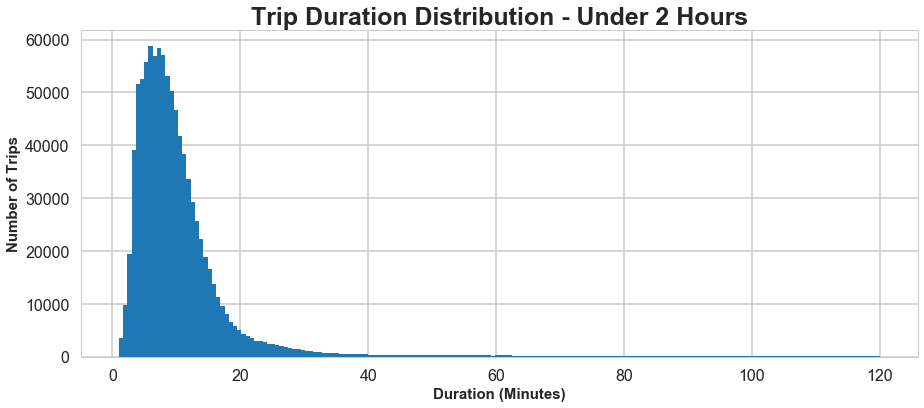

In [13]:
trips_under_120.duration_minutes.plot(kind='hist', bins=180, figsize=(15,6))
plt.xlabel('Duration (Minutes)', size=LABEL_FONT_SIZE, weight='bold')
plt.ylabel('Number of Trips', size=LABEL_FONT_SIZE, weight='bold')
plt.title('Trip Duration Distribution - Under 2 Hours', size=TITLE_FONT_SIZE, weight='bold')
plt.show()
plt.close()

# Correct Relocated Stations

<p> There was a delay in station_id updates when stations 23, 24, 25, and 26 were relocated, update status information by changing the station_id for these stations in dates after they were relocated </p>

In [14]:
def plot_terminal_trips(df, sid, date_range = (pd.Timestamp('2013-08-01'), pd.Timestamp('2016-10-01')), x_label = 'Date', y_label = 'Trips', title_suffix='', draw_dates=[], legend_loc=2):
    '''for each terminal in a trips_df, plot the number of trips starting or finishing at that terminal'''
    def group_terminal(df, start=True):
        ''' group by start or end terminal trips per day
        '''
        
        term = pd.DataFrame()
        if start:
            try:
                term = df[df['start_station_id'] == sid]
            except:
                term = df[df['start_terminal'] == sid]
        else:
            try:
                term = df[df['end_station_id'] == sid]
            except:
                term = df[df['end_terminal'] == sid]
        term.set_index('start_date', inplace=True)
        g_term = term.groupby(term.index.date)['trip_id'].count()
        
        return g_term
    
        
    start_term = group_terminal(df, start=True)
    end_term   = group_terminal(df, start=False)
    
    ax = start_term.plot(kind='line', color='c', alpha=0.75, figsize=(24,3))
    end_term.plot(kind='line', color='g', alpha=0.75, ax=ax)
    
    ax.set_xlim(date_range)
    if title_suffix != '':
        title = 'Station %s - %s' % (sid, title_suffix)
    elif y_label != '':
        title = 'Station %s - %s' % (sid, y_label)
    else:
        title = 'Station %s' % id
    ax.set_title(title, size=TITLE_FONT_SIZE, weight='bold')
    ax.set_xlabel(x_label, size=LABEL_FONT_SIZE, weight='bold')
    ax.set_ylabel(y_label, size=LABEL_FONT_SIZE, weight='bold')
    
    ax.legend(['Start Station', 'End Station'], loc=legend_loc)
    
    if len(draw_dates) > 0:
        for xc in draw_dates:
            ax.axvline(x=xc, color='k', linestyle=':', alpha=0.5)
#     plt.show()
    plt.savefig('../charts/%s.png' % title.lower().replace(' ', '_').replace('-_', ''))
    plt.close()

def date_fixes(df, old_terminal, new_terminal, change_date):
    '''Correct dates on terminal relocations, outputs graphs for quick validation of before and after'''
    print('[%s]\tUpdating %s to %s for dates after %s' % (datetime.datetime.now().time(), old_terminal, new_terminal, change_date))
    
    for station in [old_terminal, new_terminal]:
        plot_terminal_trips(df, station, title_suffix='PRE DATE FIX', draw_dates=[change_date])
        
    # Fix A to B - Start Terminal
    print('[%s]\tSettings %s to %s occuring before %s' % (datetime.datetime.now().time(), old_terminal, new_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == old_terminal) & (df.start_date >= change_date)].index
    df.loc[index_to_update_start, 'start_terminal'] = new_terminal

    # Fix A to B - End Terminal
    index_to_update_end   = df[(df.end_terminal == old_terminal) & (df.end_date >= change_date)].index
    df.loc[index_to_update_end, 'end_terminal'] = new_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())
    
    # Fix B to A - Start Terminal
    print('[%s]\tSettings %s to %s occuring after %s' % (datetime.datetime.now().time(), new_terminal, old_terminal, change_date))
    index_to_update_start = df[(df.start_terminal == new_terminal) & (df.start_date < change_date)].index
    df.loc[index_to_update_start, 'start_terminal'] = old_terminal

    # Fix B to A - End Terminal
    index_to_update_end   = df[(df.end_terminal == new_terminal) & (df.end_date < change_date)].index
    df.loc[index_to_update_end, 'end_terminal'] = old_terminal
    print('\t[%s]\tComplete!' % datetime.datetime.now().time())
    
    for station in [old_terminal, new_terminal]:
        plot_terminal_trips(df, station, draw_dates=[change_date], legend_loc=2)
    
    return df

In [15]:
trips.head()

,trip_id,duration,start_date,start_station_name,start_terminal,end_date,end_station_name,end_terminal,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,18.616667
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,18.633333


In [16]:
change_date = datetime.datetime.strptime('2016-07-05', '%Y-%m-%d')
trips = date_fixes(trips, 23, 88, change_date)
trips = date_fixes(trips, 24, 89, change_date)

[01:00:41.236148]	Updating 23 to 88 for dates after 2016-07-05 00:00:00
[01:00:41.710553]	Settings 23 to 88 occuring before 2016-07-05 00:00:00
	[01:00:42.010681]	Complete!
[01:00:42.010864]	Settings 88 to 23 occuring after 2016-07-05 00:00:00
	[01:00:42.093692]	Complete!
[01:00:42.550239]	Updating 24 to 89 for dates after 2016-07-05 00:00:00
[01:00:42.981329]	Settings 24 to 89 occuring before 2016-07-05 00:00:00
	[01:00:43.064234]	Complete!
[01:00:43.064426]	Settings 89 to 24 occuring after 2016-07-05 00:00:00
	[01:00:43.148128]	Complete!


In [17]:
change_date = datetime.datetime.strptime('2016-08-04', '%Y-%m-%d')
trips = date_fixes(trips, 25, 91, change_date)
trips = date_fixes(trips, 26, 90, change_date)

[01:00:43.612790]	Updating 25 to 91 for dates after 2016-08-04 00:00:00
[01:00:44.105215]	Settings 25 to 91 occuring before 2016-08-04 00:00:00
	[01:00:44.187883]	Complete!
[01:00:44.188058]	Settings 91 to 25 occuring after 2016-08-04 00:00:00
	[01:00:44.267499]	Complete!
[01:00:44.708876]	Updating 26 to 90 for dates after 2016-08-04 00:00:00
[01:00:45.267323]	Settings 26 to 90 occuring before 2016-08-04 00:00:00
	[01:00:45.349161]	Complete!
[01:00:45.349323]	Settings 90 to 26 occuring after 2016-08-04 00:00:00
	[01:00:45.427057]	Complete!


# Write Data to File - Basic Trip Data

In [18]:
trips.columns = ['trip_id', 'duration', 'start_date', 'start_station_name', 'start_station_id', 'end_date', 'end_station_name', 'end_station_id', 'bike_id', 'user_type', 'user_zip', 'duration_minutes']
trips.head()

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,18.616667
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,18.633333


In [19]:
trips.to_csv('../clean_data/bayareabikeshare/trip_data_basic_cleaned.csv', encoding='utf-8')

# Append Station and DarkSky Data to Trips

### Load Station and Weather Data

In [20]:
# load Station Data
stations = pd.DataFrame()
stations = pd.read_csv('../clean_data/bayareabikeshare/station_data_cleaned.csv', index_col=0, parse_dates=['first_service_date', 'last_service_date'])
stations.head()

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830


In [21]:
# load weather data
darksky = pd.DataFrame()

sf_weather = pd.read_csv('../clean_data/darksky/sanfrancisco_darksky_cleaned.csv', index_col=0, parse_dates=['time_corrected'])
print('Finished sf_weather')
sj_weather = pd.read_csv('../clean_data/darksky/sanjose_darksky_cleaned.csv', index_col=0, parse_dates=['time_corrected'])
print('Finished sj_weather')
rc_weather = pd.read_csv('../clean_data/darksky/redwoodcity_darksky_cleaned.csv', index_col=0, parse_dates=['time_corrected'])
print('Finished rc_weather')
mv_weather = pd.read_csv('../clean_data/darksky/mountainview_darksky_cleaned.csv', index_col=0, parse_dates=['time_corrected'])
print('Finished mv_weather')
pa_weather = pd.read_csv('../clean_data/darksky/paloalto_darksky_cleaned.csv', index_col=0, parse_dates=['time_corrected'])
print('Finished pa_weather')

darksky = pd.concat([sf_weather, sj_weather, rc_weather, mv_weather, pa_weather])
darksky.drop(['time'], axis=1, inplace=True)
darksky.reset_index(inplace=True, drop=True)

darksky.head()

Finished sf_weather
Finished sj_weather
Finished rc_weather
Finished mv_weather
Finished pa_weather


,apparentTemperature,cloudCover,daily_icon,daily_summary,dewPoint,hourly_icon,hourly_summary,humidity,offset,precipIntensity,...,temperature,time_corrected,visibility,windBearing,windSpeed,station_id,lat,long,zip_code,region
0,53.93,0.31,rain,"Heavy rain starting overnight, continuing unti...",50.44,partly-cloudy-night,Partly Cloudy,0.88,-8,0.0059,...,53.93,2014-12-16 00:00:00,9.29,131.0,10.26,50,37.795392,-122.394203,94107,San Francisco
1,54.72,0.00,rain,"Heavy rain starting overnight, continuing unti...",50.83,clear-night,Clear,0.87,-8,0.0059,...,54.72,2014-12-16 01:00:00,8.41,146.0,8.84,50,37.795392,-122.394203,94107,San Francisco
2,53.94,0.00,rain,"Heavy rain starting overnight, continuing unti...",50.07,clear-night,Clear,0.87,-8,0.0112,...,53.94,2014-12-16 02:00:00,8.11,149.0,8.02,50,37.795392,-122.394203,94107,San Francisco
3,53.86,0.31,rain,"Heavy rain starting overnight, continuing unti...",51.22,rain,Rain,0.91,-8,0.1668,...,53.86,2014-12-16 03:00:00,8.29,149.0,7.16,50,37.795392,-122.394203,94107,San Francisco
4,53.78,0.75,rain,"Heavy rain starting overnight, continuing unti...",51.19,rain,Rain,0.91,-8,0.1323,...,53.78,2014-12-16 04:00:00,9.47,129.0,9.66,50,37.795392,-122.394203,94107,San Francisco


In [22]:
darksky.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1586743 entries, 0 to 1586742
Data columns (total 23 columns):
apparentTemperature    1586743 non-null float64
cloudCover             1586743 non-null float64
daily_icon             1586743 non-null object
daily_summary          1586743 non-null object
dewPoint               1586743 non-null float64
hourly_icon            1586743 non-null object
hourly_summary         1586743 non-null object
humidity               1586743 non-null float64
offset                 1586743 non-null int64
precipIntensity        1586743 non-null float64
precipProbability      1586743 non-null float64
precipType             1586743 non-null int64
pressure               1586743 non-null float64
temperature            1586743 non-null float64
time_corrected         1586743 non-null datetime64[ns]
visibility             1586743 non-null float64
windBearing            1586743 non-null float64
windSpeed              1586743 non-null float64
station_id             1

# Append Data to Trips

In [23]:
print('trips.shape\t%s\t%s' % (trips.shape[0], trips.shape[1]))
print('stations.shape\t%s\t%s' % (stations.shape[0], stations.shape[1]))
print('darksky.shape\t%s\t%s' % (darksky.shape[0], darksky.shape[1]))

trips.shape	983352	12
stations.shape	79	12
darksky.shape	1586743	23


In [24]:
trip_id_list = sorted(list(trips.trip_id.unique()))

In [25]:
trips.head(5)

,trip_id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,user_type,user_zip,duration_minutes
0,4069,174,2013-08-29 09:08:00,2nd at South Park,64,2013-08-29 09:11:00,2nd at South Park,64,288,Subscriber,94114,2.900000
1,4073,1067,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:42:00,San Francisco Caltrain 2 (330 Townsend),69,321,Subscriber,94703,17.783333
2,4074,1131,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,317,Subscriber,94115,18.850000
3,4075,1117,2013-08-29 09:24:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,316,Subscriber,94122,18.616667
4,4076,1118,2013-08-29 09:25:00,South Van Ness at Market,66,2013-08-29 09:43:00,San Francisco Caltrain 2 (330 Townsend),69,322,Subscriber,94597,18.633333


In [26]:
stations.head(5)

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-29,2016-08-31,95113,1098,28.275824,92.768450
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-29,2016-08-31,95113,1098,28.038095,91.988502
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-29,2016-08-31,95113,1098,25.517740,83.719620
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-29,2016-08-31,95113,1098,26.192633,85.933834
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-29,2016-08-31,95113,1098,25.543407,83.803830


In [27]:
stations[stations.station_id.isin(stations[stations.duplicated(subset='station_id')].station_id.unique())]

,station_id,station_name,lat,long,dock_count,region,first_service_date,last_service_date,zip_code,days_in_service,elevation_meters,elevation_feet
14,21,Franklin at Maple,37.481758,-122.226904,15,Redwood City,2013-08-29,2015-09-14,94063,746,5.202400,17.068242
15,21,Sequoia Hospital,37.479303,-122.253755,15,Redwood City,2015-09-15,2016-06-30,94063,289,30.651674,100.563236
19,25,Stanford in Redwood City,37.485370,-122.203288,15,Redwood City,2013-08-29,2014-08-31,94063,367,2.523256,8.278398
20,25,Broadway at Main,37.486725,-122.225551,15,Redwood City,2014-09-01,2016-08-03,94063,702,2.866423,9.404274
25,30,Evelyn Park and Ride,37.390277,-122.066553,15,Mountain View,2013-08-29,2015-09-27,94041,759,27.981312,91.802204
26,30,Middlefield Light Rail Station,37.395337,-122.052476,15,Mountain View,2015-09-28,2016-08-31,94041,338,19.697617,64.624726
29,33,Rengstorff Avenue / California Street,37.400241,-122.099076,15,Mountain View,2013-08-29,2015-09-14,94041,746,19.398766,63.644244
30,33,Charleston Park/ North Bayshore Area,37.420909,-122.080623,15,Mountain View,2015-09-15,2016-08-31,94041,351,3.377911,11.082385
65,73,Grant Avenue at Columbus Avenue,37.798522,-122.407245,15,San Francisco,2013-08-29,2015-05-19,94107,628,26.583323,87.215625
66,73,Grant Avenue at Columbus Avenue,37.797900,-122.405942,19,San Francisco,2015-05-20,2016-08-31,94107,469,20.935102,68.684719


In [28]:
start_stations = stations.copy()
start_stations.drop(['lat', 'long', 'dock_count', 'zip_code', 'days_in_service'], axis=1, inplace=True)

start_stations.columns = [str('start_station_%s' % x).replace('station_station_', 'station_') for x in start_stations.columns]
print(start_stations.columns)


end_stations   = stations.copy()
end_stations.drop(['lat', 'long', 'dock_count', 'zip_code', 'days_in_service'], axis=1, inplace=True)

end_stations.columns = [str('end_station_%s' % x).replace('station_station_', 'station_') for x in end_stations.columns]
print(end_stations.columns)

Index(['start_station_id', 'start_station_name', 'start_station_region',
       'start_station_first_service_date', 'start_station_last_service_date',
       'start_station_elevation_meters', 'start_station_elevation_feet'],
      dtype='object')
Index(['end_station_id', 'end_station_name', 'end_station_region',
       'end_station_first_service_date', 'end_station_last_service_date',
       'end_station_elevation_meters', 'end_station_elevation_feet'],
      dtype='object')


## Append Station Data
<p>Append Information about start and end stations</p>
<p>Calculate elevation change in meters and feet</p>

In [29]:
trips_stations = pd.DataFrame()
# trips_stations = trips.merge(start_stations, left_on=['start_station_id', 'start_station_name'], right_on=['start_station_id', 'start_station_name'], how='left')
trips_stations = trips.merge(start_stations, left_on=['start_station_id'], right_on=['start_station_id'], how='left')
print(trips_stations.shape)

# trips_stations = trips_stations.merge(end_stations, left_on=['end_station_id', 'end_station_name'], right_on=['end_station_id', 'end_station_name'], how='left')
trips_stations = trips_stations.merge(end_stations, left_on=['end_station_id'], right_on=['end_station_id'], how='left')
print(trips_stations.shape)

(1010866, 18)
(1029269, 24)


### Prune duplicated trips by dates 

In [30]:
trips_stations = trips_stations[(trips_stations.start_date.dt.date <= trips_stations.start_station_last_service_date.dt.date) & (trips_stations.start_date.dt.date >= trips_stations.start_station_first_service_date.dt.date)]
trips_stations.shape

(1000483, 24)

In [31]:
trips_stations = trips_stations[(trips_stations.end_date.dt.date <= trips_stations.start_station_last_service_date.dt.date) & (trips_stations.end_date.dt.date >= trips_stations.start_station_first_service_date.dt.date)]
trips_stations.shape

(1000482, 24)

In [32]:
trips_stations = trips_stations[(trips_stations.start_date.dt.date <= trips_stations.end_station_last_service_date.dt.date) & (trips_stations.start_date.dt.date >= trips_stations.end_station_first_service_date.dt.date)]
trips_stations.shape

(983350, 24)

In [33]:
trips_stations = trips_stations[(trips_stations.end_date.dt.date <= trips_stations.end_station_last_service_date.dt.date) & (trips_stations.end_date.dt.date >= trips_stations.end_station_first_service_date.dt.date)]
trips_stations.shape

(983350, 24)

In [34]:
# drop no longer needed first and last service dates
drop_cols = ['start_station_name_x', 'end_station_name_x', 'start_station_last_service_date', 'start_station_first_service_date', 'end_station_last_service_date', 'end_station_first_service_date']
trips_stations.drop(drop_cols, axis=1, inplace=True)

trips_stations.rename(columns={'start_station_name_y': 'start_station_name', 'end_station_name_y': 'end_station_name'}, inplace=True)

trips_stations['elevation_change_meters'] = trips_stations.start_station_elevation_meters - trips_stations.end_station_elevation_meters
trips_stations['elevation_change_feet']   = trips_stations.start_station_elevation_feet - trips_stations.end_station_elevation_feet

trips_stations.reset_index(inplace=True, drop=True)

In [35]:
trips_stations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 983350 entries, 0 to 983349
Data columns (total 20 columns):
trip_id                           983350 non-null int64
duration                          983350 non-null int64
start_date                        983350 non-null datetime64[ns]
start_station_id                  983350 non-null int64
end_date                          983350 non-null datetime64[ns]
end_station_id                    983350 non-null int64
bike_id                           983350 non-null int64
user_type                         983350 non-null category
user_zip                          983350 non-null int64
duration_minutes                  983350 non-null float64
start_station_name                983350 non-null object
start_station_region              983350 non-null object
start_station_elevation_meters    983350 non-null float64
start_station_elevation_feet      983350 non-null float64
end_station_name                  983350 non-null object
end_station_region 

## Append DarkSky Weather Data
<p>Only need information at start time and location</p>

In [36]:
trips_stations.head()

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,user_type,user_zip,duration_minutes,start_station_name,start_station_region,start_station_elevation_meters,start_station_elevation_feet,end_station_name,end_station_region,end_station_elevation_meters,end_station_elevation_feet,elevation_change_meters,elevation_change_feet
0,4069,174,2013-08-29 09:08:00,64,2013-08-29 09:11:00,64,288,Subscriber,94114,2.900000,2nd at South Park,San Francisco,13.151367,43.147530,2nd at South Park,San Francisco,13.151367,43.147530,0.00000,0.000000
1,4073,1067,2013-08-29 09:24:00,66,2013-08-29 09:42:00,69,321,Subscriber,94703,17.783333,South Van Ness at Market,San Francisco,15.628606,51.274954,San Francisco Caltrain 2 (330 Townsend),San Francisco,3.019796,9.907466,12.60881,41.367488
2,4074,1131,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,317,Subscriber,94115,18.850000,South Van Ness at Market,San Francisco,15.628606,51.274954,San Francisco Caltrain 2 (330 Townsend),San Francisco,3.019796,9.907466,12.60881,41.367488
3,4075,1117,2013-08-29 09:24:00,66,2013-08-29 09:43:00,69,316,Subscriber,94122,18.616667,South Van Ness at Market,San Francisco,15.628606,51.274954,San Francisco Caltrain 2 (330 Townsend),San Francisco,3.019796,9.907466,12.60881,41.367488
4,4076,1118,2013-08-29 09:25:00,66,2013-08-29 09:43:00,69,322,Subscriber,94597,18.633333,South Van Ness at Market,San Francisco,15.628606,51.274954,San Francisco Caltrain 2 (330 Townsend),San Francisco,3.019796,9.907466,12.60881,41.367488


In [37]:
darksky.head()

,apparentTemperature,cloudCover,daily_icon,daily_summary,dewPoint,hourly_icon,hourly_summary,humidity,offset,precipIntensity,...,temperature,time_corrected,visibility,windBearing,windSpeed,station_id,lat,long,zip_code,region
0,53.93,0.31,rain,"Heavy rain starting overnight, continuing unti...",50.44,partly-cloudy-night,Partly Cloudy,0.88,-8,0.0059,...,53.93,2014-12-16 00:00:00,9.29,131.0,10.26,50,37.795392,-122.394203,94107,San Francisco
1,54.72,0.00,rain,"Heavy rain starting overnight, continuing unti...",50.83,clear-night,Clear,0.87,-8,0.0059,...,54.72,2014-12-16 01:00:00,8.41,146.0,8.84,50,37.795392,-122.394203,94107,San Francisco
2,53.94,0.00,rain,"Heavy rain starting overnight, continuing unti...",50.07,clear-night,Clear,0.87,-8,0.0112,...,53.94,2014-12-16 02:00:00,8.11,149.0,8.02,50,37.795392,-122.394203,94107,San Francisco
3,53.86,0.31,rain,"Heavy rain starting overnight, continuing unti...",51.22,rain,Rain,0.91,-8,0.1668,...,53.86,2014-12-16 03:00:00,8.29,149.0,7.16,50,37.795392,-122.394203,94107,San Francisco
4,53.78,0.75,rain,"Heavy rain starting overnight, continuing unti...",51.19,rain,Rain,0.91,-8,0.1323,...,53.78,2014-12-16 04:00:00,9.47,129.0,9.66,50,37.795392,-122.394203,94107,San Francisco


In [38]:
print('[%s]\tAppending DarkSky Weather Data...' % datetime.datetime.now().time())

trips_complete_df = pd.merge(trips_stations, 
                          darksky, 
                          how='left', 
                          left_on=[trips_stations.start_date.dt.date, trips_stations.start_date.dt.hour, 'start_station_id'], 
                          right_on=[darksky.time_corrected.dt.date, darksky.time_corrected.dt.hour, 'station_id'])
print('\t[%s]\tComplete!' % datetime.datetime.now().time())

[01:02:46.142722]	Appending DarkSky Weather Data...
	[01:03:02.611158]	Complete!


In [39]:
trips_complete_df.drop(['zip_code', 'region', 'lat', 'long', 'station_id', 'offset'], axis=1, inplace=True)

trips_complete_df.rename(columns={'time_corrected': 'forecast_time'}, inplace=True)
trips_complete_df.drop_duplicates(subset=['trip_id'], inplace=True)
trips_complete_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 983350 entries, 0 to 1010724
Data columns (total 37 columns):
trip_id                           983350 non-null int64
duration                          983350 non-null int64
start_date                        983350 non-null datetime64[ns]
start_station_id                  983350 non-null int64
end_date                          983350 non-null datetime64[ns]
end_station_id                    983350 non-null int64
bike_id                           983350 non-null int64
user_type                         983350 non-null category
user_zip                          983350 non-null int64
duration_minutes                  983350 non-null float64
start_station_name                983350 non-null object
start_station_region              983350 non-null object
start_station_elevation_meters    983350 non-null float64
start_station_elevation_feet      983350 non-null float64
end_station_name                  983350 non-null object
end_station_region

In [40]:
trips_complete_df.tail()

,trip_id,duration,start_date,start_station_id,end_date,end_station_id,bike_id,user_type,user_zip,duration_minutes,...,humidity,precipIntensity,precipProbability,precipType,pressure,temperature,forecast_time,visibility,windBearing,windSpeed
1010720,1338404,511,2016-08-31 23:05:00,42,2016-08-31 23:14:00,47,370,Subscriber,94109,8.516667,...,0.86,0.0,0.0,0.0,1014.26,60.79,2016-08-31 23:00:00,8.57,216.0,4.15
1010721,1338405,701,2016-08-31 23:06:00,70,2016-08-31 23:17:00,49,175,Subscriber,94133,11.683333,...,0.86,0.0,0.0,0.0,1014.35,60.64,2016-08-31 23:00:00,8.80,223.0,5.31
1010722,1338406,457,2016-08-31 23:06:00,42,2016-08-31 23:13:00,49,504,Subscriber,94111,7.616667,...,0.86,0.0,0.0,0.0,1014.26,60.79,2016-08-31 23:00:00,8.57,216.0,4.15
1010723,1338407,260,2016-08-31 23:09:00,54,2016-08-31 23:14:00,74,226,Subscriber,94114,4.333333,...,0.86,0.0,0.0,0.0,1014.28,60.83,2016-08-31 23:00:00,8.62,219.0,5.03
1010724,1338408,378,2016-08-31 23:32:00,46,2016-08-31 23:38:00,60,667,Subscriber,94111,6.300000,...,0.86,0.0,0.0,0.0,1014.25,60.74,2016-08-31 23:00:00,8.55,220.0,4.90


# Write Data to File - Complete Trip Data

In [41]:
for year in sorted(trips_complete_df.start_date.dt.year.unique()):
    year_trips = trips_complete_df[trips_complete_df.start_date.dt.year == year].copy()
    year_trips.reset_index(inplace=True, drop=True)
    
    year_trips.to_csv('../clean_data/bayareabikeshare/trip_data_extended_cleaned_%s.csv' % year, encoding='utf-8')
    print(year)

2013
2014
2015
2016


In [42]:
trips_complete_df.to_csv('../clean_data/bayareabikeshare/trip_data_extended_cleaned.csv', encoding='utf-8')

***
# Preview EDA of Stations Data

In [43]:
x_ticks = sorted(pd.unique(trips_complete_df.start_date.dt.hour))
subscriber_y = trips_complete_df[trips_complete_df.user_type == 'Subscriber'].groupby(trips_complete_df.start_date.dt.hour)['trip_id'].count()
customer_y   = trips_complete_df[trips_complete_df.user_type == 'Customer'].groupby(trips_complete_df.start_date.dt.hour)['trip_id'].count()
sub_norm  = subscriber_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))
cust_norm =   customer_y.to_frame().apply(lambda x: x / (np.max(x) - np.min(x)))

# Trips by Hour by Customer Type
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = subscriber_y, color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = customer_y, color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Total Trips', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend(loc=1, frameon=True)
plt.savefig('../charts/03_Trips_Per_Hour.png')
plt.close('all')

# Normalized Trips by Hour by Customer Type
plt.subplots(figsize=(15,6))
ax = sns.barplot(x = x_ticks , y = sub_norm['trip_id'], color='b', alpha = 0.5, label='Subscribers')
sns.barplot(x = x_ticks , y = cust_norm['trip_id'], color='r', alpha = 0.5, label='Customers', ax=ax)

ax.set_title('Distribution of Trips by Hour (Normalized)', size=TITLE_FONT_SIZE, weight='bold')
ax.set_xlabel('Start Hour', size=LABEL_FONT_SIZE, weight='bold')
ax.set_ylabel('Distribution', size=LABEL_FONT_SIZE, weight='bold')
ax.set_xticks(x_ticks)

plt.legend(loc=1, frameon=True)
plt.savefig('../charts/Program_Trips_Per_Hour_Noramlized.png')
plt.close('all')


# Quick Reference to some 'Special Stations'
<p>Some stations were relocated, closed, or expanded during the program's recorded dataset being used in this analysis, this is a quick view to these notable stations</p>
<ul>
    <li> Station 21 - Relocated on September 16, 2015
    <li> Station 30 - Relocated on September 28, 2015
    <li> Station 33 - Relocated on September 16, 2015
    <li> Station 73 - Relocated on March 14, 2016 and May 19, 2016 had 4 extra docks added
</ul>

In [44]:
# Station 21 Review
s21_dates = ['2013-08-29', '2015-09-16', '2016-08-04']
plot_terminal_trips(trips_complete_df, 21, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s21_dates, legend_loc=1)

# Station 30 Review
s30_dates = ['2013-08-29', '2015-09-28', '2016-08-31']
plot_terminal_trips(trips_complete_df, 30, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s30_dates, legend_loc=1)

# Station 33 Review
s33_dates = ['2013-08-29', '2015-09-16', '2016-08-31']
plot_terminal_trips(trips_complete_df, 33, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s33_dates, legend_loc=1)

# Station 73 Review
s73_dates = ['2013-08-29', '2015-05-19', '2016-08-31']
plot_terminal_trips(trips_complete_df, 73, x_label = 'Date', y_label = 'Trips', title_suffix='Review', draw_dates=s73_dates, legend_loc=1)